## Introduction

One of the ways to manufacture metal products is through a process called casting, in which liquid metal is poured into a mold to harden. Casting products may contain irregularities or defects and thus must be inspected prior shipping to ensure that customer specifications are met. Accurate inspection is important because defective products can cause rejection of the whole production order by the customers, resulting in financial loss for the casting company.

Visual inspection is a non-destructive technique to detect flaws on casting products. It involves an inspector looking at each test piece with the naked eye and then classifying the product as either defective or OK based on his assessment. Due to its reliance on human factors, however, visual inspection is prone to misclassification and can be time-consuming.

This project explores automation of visual inspection with computer vision. A deep learning model called convolutional neural networks (CNN) is created to distinguish images of defective and non-defective castings.

### Import Dependancies 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

### Dataset

The casting product data comprises top-view JPEG images of cast submersible pump impellers, provided by Pilot Technocast. Images were captured with Canon EOS 1300D DSLR camera. Every images are 300×300 pixels in size and already labeled as either def_front (defective castings) or ok_front (non-defective).

The folder train in the input directory contains images that are used for model training/validation. Images located in the test folder are used to test the trained model's performance.

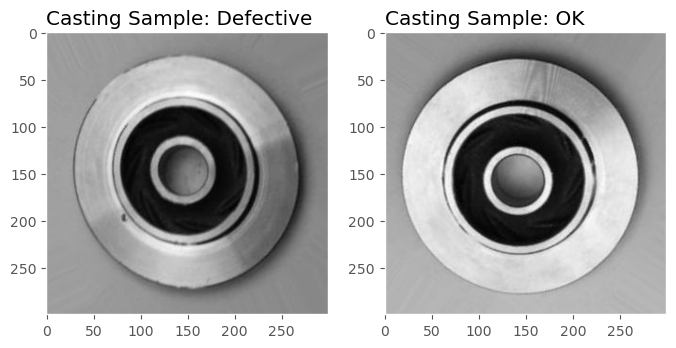

In [2]:
# Specify directory of train data
dir_train_def = "C:/Users/Harshal/Downloads/casting_data/train_Casting/def_front"  # Class label: Defective
dir_train_ok = "C:/Users/Harshal/Downloads/casting_data/train_Casting/ok_front"    # Class label: OK

# Specify directory of test data
dir_test_def = "C:/Users/Harshal/Downloads/casting_data/test_casting/def_front"
dir_test_ok = "C:/Users/Harshal/Downloads/casting_data/test_casting/ok_front"

# Plot samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Get the first file in each directory
sample_def_file = os.path.join(dir_train_def, os.listdir(dir_train_def)[0])
sample_ok_file = os.path.join(dir_train_ok, os.listdir(dir_train_ok)[0])

# Read and plot the images
sample_def = plt.imread(sample_def_file)
sample_ok = plt.imread(sample_ok_file)

axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective', loc='left')
axes[1].set_title('Casting Sample: OK', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()

We are performing a classification predictive modeling which involves assigning a class label (Defective or OK) for a given image of casting product. To prevent the model from making a biased prediction, the dataset must be checked for class imbalance. As shown in the following plot, there is uneven distribution between Defective and OK. However, considering the class imbalance is only by a small amount (6:4), the problem can be treated like a normal classification predictive modeling.

In [4]:
# Create dataframe of class distribution
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])

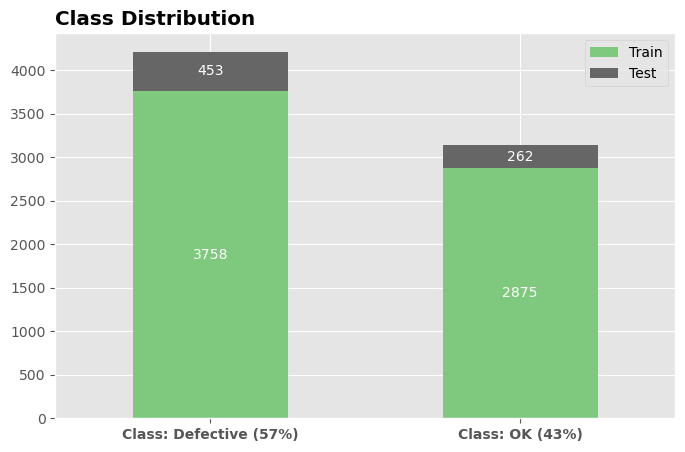

In [5]:
# Visualize class distribution
ax = dist_df.T.plot(kind='bar', stacked=True, rot=0, figsize=(8,5), colormap='Accent')
ax.set_title('Class Distribution', loc='left', weight='bold')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25, 
            bar.get_y()+bar.get_height()/2,
            int(bar.get_height()),
            ha='center', va='center', color='white')
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()
pct_ok = 100-pct_def
ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'], weight='bold')
plt.show()

### Data Preprocessing

The first step of preparing the data is to normalize pixel values (originally between 0 and 255) to a range of 0 to 1. This is done by passing the rescale arguments on instances of Keras ImageDataGenerator for train and test sets.

With the train set generator we specify validation_split=0.2 to reserve 20% of data for validation. The function flow_from_directory() is then used on the data generators for each of train/ and test/ directories. Arguments for data generation are also specified:

- Target image size is 300×300 pixels
- color_mode='grayscale' to convert images as having 1 channel
- Define class mapping: 0 for OK, 1 for Defective
- class_mode='binary' since there are two classes
- Batch size fixed at 64

In [6]:
# Define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1./255)

In [7]:
# Specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

In [8]:
dir_train = "C:/Users/Harshal/Downloads/casting_data/train_Casting"
dir_test = "C:/Users/Harshal/Downloads/casting_data/test_Casting"

In [9]:
# Generate data by iterating through directories
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)
valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


### Model Building

We will use convolutional neural networks to approach the problem of classifying whether a casting is Defective or OK based on the given image. Almost universally used in computer vision applications, convolutional neural networks (CNN, convnets) is a type of deep-learning model that can look at groups of adjacent pixels in an area of an image and learn to find spatial patterns.

CNN is made up of a number of layers: a series of convolutional layers (with activation), pooling layers, and at least one final fully-connected layer that produces a set of class scores for a given image. The convolutional layers of a CNN act as feature extractors; they extract shape and color patterns from the pixel values of training images.

More in-depth explanations of how each CNN layer works can be found on this awesome blog by Cezanne Camacho.

For our model, we will adapt the general architectural principles of the VGG models. The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer, together forming a block. These blocks can be repeated with increasing number of filters such as 32, 64, 120, 256.

Padding is used on the convolutional layers to ensure same height and width between input and output. ReLU activation function is applied on every layer except the last one. Since a binary classification task requires a prediction of either a value of 0 or 1, the output layer is defined with 1 node and a sigmoid activation function.

The model is fit with Adam optimizer (learning rate of 0.001) and with binary cross-entropy loss function. The metric with which to monitor model training is accuracy.

In [10]:
# Define CNN model architecture
cnn_model = Sequential([ 
    Conv2D(32, 3, activation='relu', padding='same', strides=2, input_shape=img_size+(1,)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(1, activation='sigmoid')       
])

In [11]:
cnn_model.compile(
optimizer=Adam(learning_rate=0.001),  
    loss='binary_crossentropy',
    metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dense (Dense)               (None, 120)               2

### Model Training and Evaluation

The model is trained for 20 epochs, each requiring 83 steps for all image batches to pass through the network. The ModelCheckpoint callback is specified to save the model at an epoch that yields the best value of val_loss (when it is most minimized). We will later load the saved model to make predictions on the test set.

In [12]:
n_epochs = 20
cnn_model.fit(train_set,validation_data=valid_set,epochs=n_epochs,callbacks=ModelCheckpoint('CNN_Casting_Inspection.hdf5',save_best_only=True,monitor='val_loss'),verbose=1)

Epoch 1/20
83/83 [==============================] - 52s 607ms/step - loss: 0.6568 - accuracy: 0.6116 - val_loss: 0.5355 - val_accuracy: 0.7202
Epoch 2/20
83/83 [==============================] - 50s 602ms/step - loss: 0.4374 - accuracy: 0.7908 - val_loss: 0.3157 - val_accuracy: 0.8861
Epoch 3/20
83/83 [==============================] - 51s 612ms/step - loss: 0.3030 - accuracy: 0.8751 - val_loss: 0.2681 - val_accuracy: 0.8974
Epoch 4/20
83/83 [==============================] - 50s 597ms/step - loss: 0.2292 - accuracy: 0.9109 - val_loss: 0.2259 - val_accuracy: 0.9050
Epoch 5/20
83/83 [==============================] - 49s 593ms/step - loss: 0.1654 - accuracy: 0.9412 - val_loss: 0.1354 - val_accuracy: 0.9593
Epoch 6/20
83/83 [==============================] - 50s 595ms/step - loss: 0.1007 - accuracy: 0.9740 - val_loss: 0.0895 - val_accuracy: 0.9721
Epoch 7/20
83/83 [==============================] - 49s 585ms/step - loss: 0.1064 - accuracy: 0.9631 - val_loss: 0.1511 - val_accuracy: 0.9397

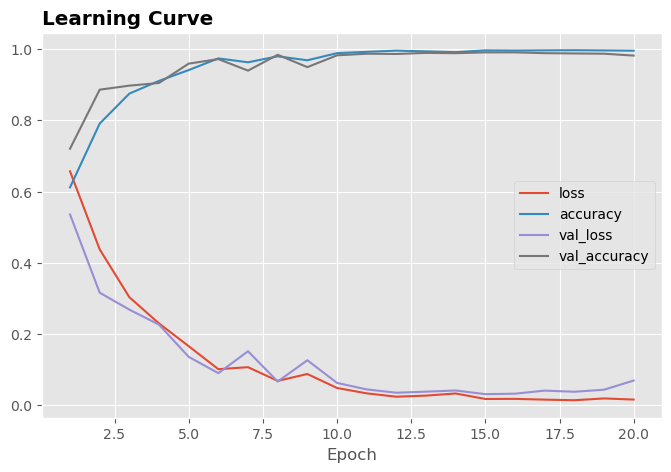

In [13]:
# Plot learning curve from model history
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))
fig, ax = plt.subplots(figsize=(8,5))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)
ax.set_xlabel('Epoch')
ax.set_title('Learning Curve', loc='left', weight='bold')
ax.legend()
plt.show()

Accuracies of the model generally increase while loss decrease with increasing epoch. It can also be observed that training and validation curves are closely aligned, indicating that the model does not result in overfitting and may perform well on classifying images from the test set. Epoch 20 achieved best performance with the following results:

- 99.57% training accuracy,
- 98.19% validation accuracy.

### Using Model to Classify New Images
The trained model is used to predict the class of images that weren't previously included in the training and validation process. The classification will output a probability score between 0-1 and a threshold value of 0.5 is specified to separate the classes. A probability score that is equal to or greater than this threshold is classified as Defective, otherwise OK.

In [14]:
# Load saved model
best_model = load_model('./CNN_Casting_Inspection.hdf5')

# Make predictions on images in the test set
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]

12/12 [==============================] - 3s 220ms/step


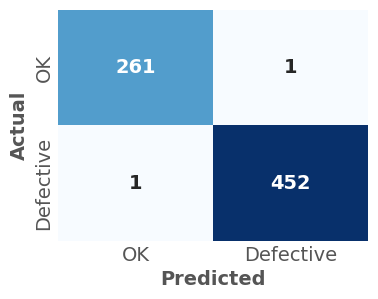

In [15]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [16]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9962    0.9962    0.9962       262
           1     0.9978    0.9978    0.9978       453

    accuracy                         0.9972       715
   macro avg     0.9970    0.9970    0.9970       715
weighted avg     0.9972    0.9972    0.9972       715



An overall classification accuracy of 99.72% is achieved by the trained model which means that, out of 715 test images, there are 4 cases of misclassification. On predicting whether or not an image is of Defective casting. 

False negatives (mis-detections), i.e., cases when Defective castings are predicted as OK, must be minimized as it may cause revenue loss for the casting company due to rejection of the whole production order by customer. On the other hand, false positives (over-detection) may increase waste and production cost, not to mention unnecessary downtime.

The metric recall helps us evaluate model performance when the cost of false negatives is high. Alternatively, when the cost of false positives is high, the metric precision is prioritized. However, since both cases of misclassification negatively impact the business, F1-score can be selected as a performance metric. F1-score is an overall measure of a model's accuracy that combines precision and recall.

1/1 [==============================] - 0s 35ms/step


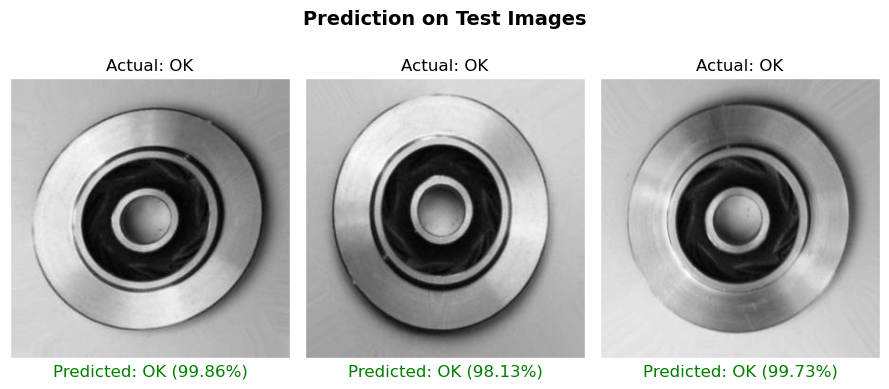

In [23]:
class_map = {0: 'OK', 1: 'Defective'}
images, labels = next(iter(test_set))
images = images.reshape(batch_size,*img_size)

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
fig.suptitle('Prediction on Test Images', y=0.98, weight='bold', size=14)
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[label]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 39ms/step


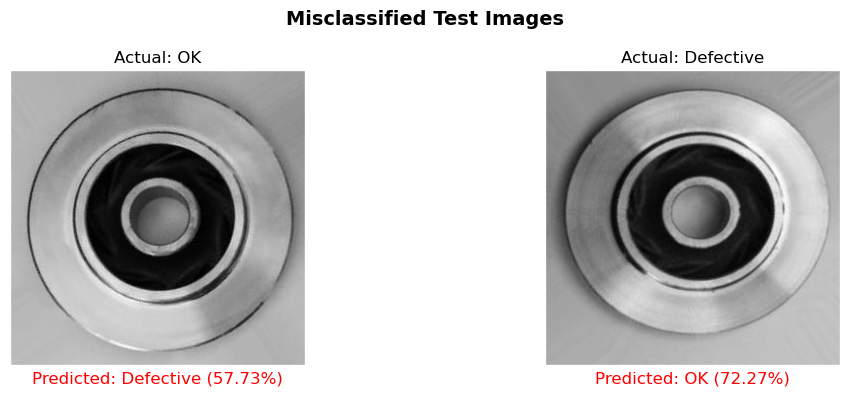

In [25]:
misclassified = np.nonzero(y_pred != y_true)[0]
batch_num = misclassified//batch_size
image_num = misclassified%batch_size

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Misclassified Test Images', y=0.98, weight='bold', size=14)
for ax, bnum, inum in zip(axes.flat, batch_num, image_num):
    images, labels = test_set[bnum]
    img = images[inum]
    ax.imshow(img.reshape(*img_size), cmap='gray')
    [[pred_prob]] = best_model.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=0.5)]
    true_label = class_map[labels[inum]]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

### Conclusion:

A convolutional neural networks model was created to classify images of a casting product as either Defective or OK and achieved a good performance based on F1-score (99.62%). Results of this project suggest viability of deep learning method in automating visual inspection. Incorporation of this method in the production line can provide support for trained inspectors in making better assessments of product quality.